Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

class: SingleCellExperiment 
dim: 48801 2327 
metadata(0):
assays(2): counts logcounts
rownames(48801): ERCC-00002 ERCC-00003 ... ENSMUSG00000064371
  ENSMUSG00000064372
rowData names(6): Geneid Chr ... Strand Length
colnames(2327): B13.B002229.1_52.1.32.1_S109
  B13.B002297.1_32.4.52.1_S73 ... P9.B002345.5_52.1.32.1_S93
  P9.B002450.5_4.52.16.1_S261
colData names(11): CellID ClusterID ... SubType sizeFactor
reducedDimNames(1): PCA
mainExpName: NULL
altExpNames(0):

Constructing kNN graph with k:10

Checking valid object

Running refined sampling with graph

Checking meta.data validity

Counting cells in neighbourhoods




16wk  1wk 32wk  4wk 52wk 
   5    5    5    5    5 

Using TMM normalisation

Performing spatial FDR correction withgraph-overlap weighting




FALSE  TRUE 
  193    19 

,Age1wk - Age4wk,Age4wk - Age16wk,Age16wk - Age32wk,Age32wk - Age52wk
Age16wk,0,-1,1,0
Age1wk,1,0,0,0
Age32wk,0,0,-1,1
Age4wk,-1,1,0,0
Age52wk,0,0,0,-1


,Age1wk - (Age4wk + Age16wk + Age32wk + Age52wk)/4
Age16wk,-0.25
Age1wk,1.00
Age32wk,-0.25
Age4wk,-0.25
Age52wk,-0.25


Using TMM normalisation

Performing spatial FDR correction withgraph-overlap weighting




FALSE  TRUE 
  143    69 

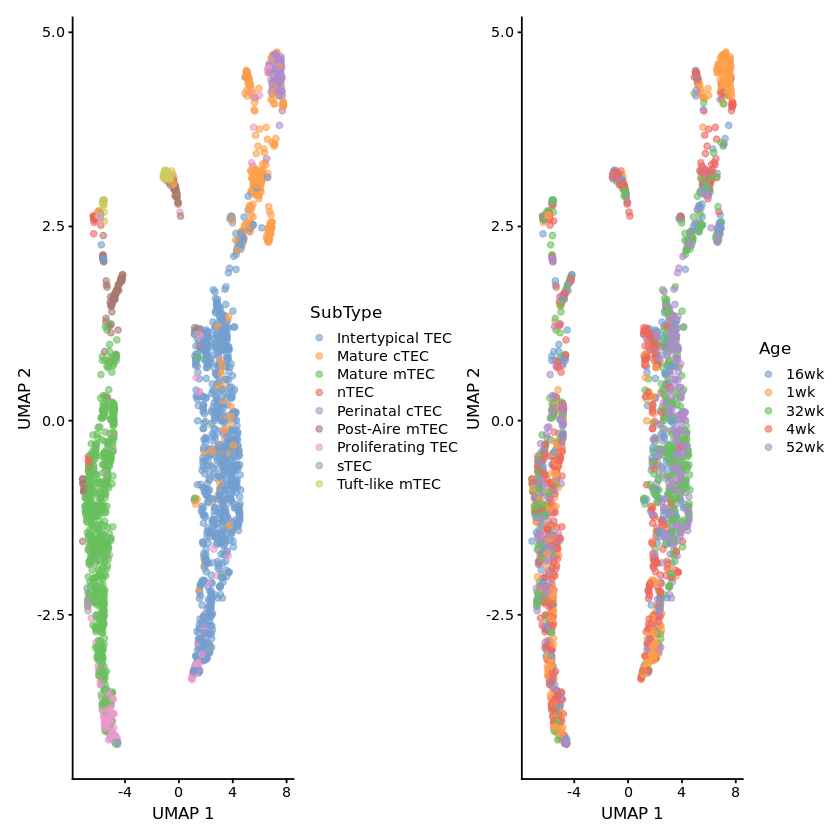

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux

Matrix products: default
BLAS/LAPACK: /nfsdata/tools/anaconda/envs/nmq407/fgf1/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] MouseThymusAgeing_1.2.0     patchwork_1.1.1            
 [3] dplyr_1.0.9                 scran_1.22.1               
 [5] scater_1.25.5               ggplot2_3.3.6              
 [7] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [9] SummarizedExperiment_1.24.0 Bi

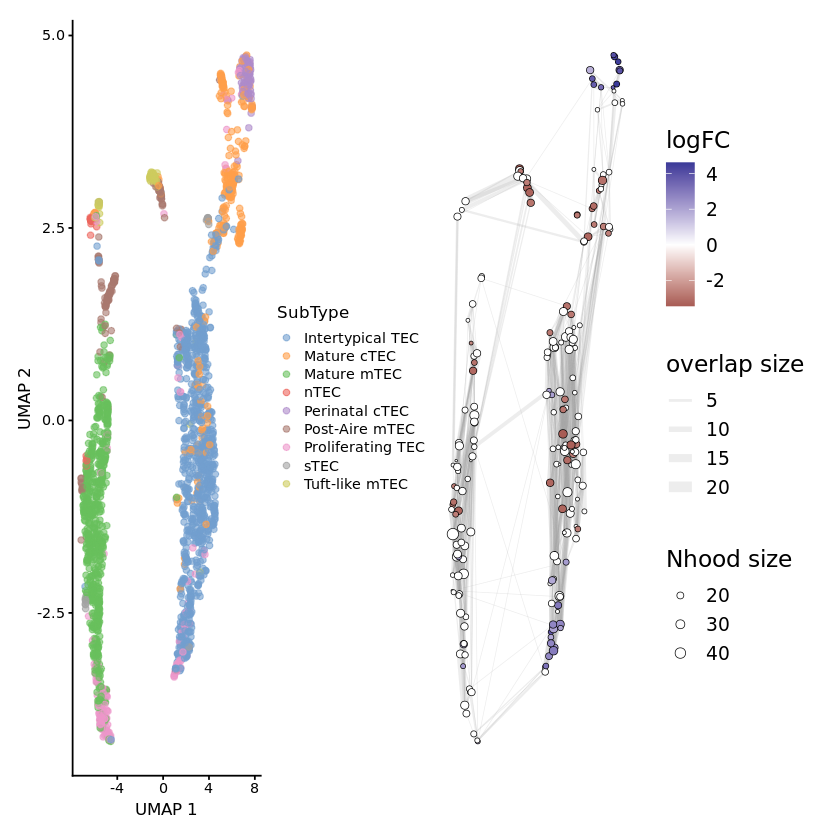

In [1]:
## ----setup, message=FALSE, warning=FALSE--------------------------------------
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(MouseThymusAgeing)
library(scuttle)

## -----------------------------------------------------------------------------
thy.sce <- MouseSMARTseqData() # this function downloads the full SCE object
thy.sce <- logNormCounts(thy.sce)
thy.sce

## ---- fig.height=4.1, fig.width=10.5------------------------------------------
thy.sce <- runUMAP(thy.sce) # add a UMAP for plotting results later

thy.milo <- Milo(thy.sce) # from the SCE object
reducedDim(thy.milo, "UMAP") <- reducedDim(thy.sce, "UMAP")

plotUMAP(thy.milo, colour_by="SubType") + plotUMAP(thy.milo, colour_by="Age")

## -----------------------------------------------------------------------------
# we build KNN graph
thy.milo <- buildGraph(thy.milo, k = 10, d = 30)
thy.milo <- makeNhoods(thy.milo, prop = 0.1, k = 10, d=30, refined = TRUE, refinement_scheme="graph") # make nhoods using graph-only as this is faster
colData(thy.milo)$Sample <- paste(colData(thy.milo)$SortDay, colData(thy.milo)$Age, sep="_")
thy.milo <- countCells(thy.milo, meta.data = data.frame(colData(thy.milo)), samples="Sample") # make the nhood X sample counts matrix

## -----------------------------------------------------------------------------
thy.design <- data.frame(colData(thy.milo))[,c("Sample", "SortDay", "Age")]
thy.design <- distinct(thy.design)
rownames(thy.design) <- thy.design$Sample
## Reorder rownames to match columns of nhoodCounts(milo)
thy.design <- thy.design[colnames(nhoodCounts(thy.milo)), , drop=FALSE]
table(thy.design$Age)

## -----------------------------------------------------------------------------
rownames(thy.design) <- thy.design$Sample
contrast.1 <- c("Age1wk - Age4wk") # the syntax is <VariableName><ConditionLevel> - <VariableName><ControlLevel>

# we need to use the ~ 0 + Variable expression here so that we have all of the levels of our variable as separate columns in our model matrix
da_results <- testNhoods(thy.milo, design = ~ 0 + Age, design.df = thy.design, model.contrasts = contrast.1, fdr.weighting="graph-overlap")
table(da_results$SpatialFDR < 0.1)

## -----------------------------------------------------------------------------
contrast.all <- c("Age1wk - Age4wk", "Age4wk - Age16wk", "Age16wk - Age32wk", "Age32wk - Age52wk")

# this is the edgeR code called by `testNhoods`
model <- model.matrix(~ 0 + Age, data=thy.design)
mod.constrast <- makeContrasts(contrasts=contrast.all, levels=model)

mod.constrast

## -----------------------------------------------------------------------------
model <- model.matrix(~ 0 + Age, data=thy.design)
ave.contrast <- c("Age1wk - (Age4wk + Age16wk + Age32wk + Age52wk)/4")
mod.constrast <- makeContrasts(contrasts=ave.contrast, levels=model)

mod.constrast

## -----------------------------------------------------------------------------
da_results <- testNhoods(thy.milo, design = ~ 0 + Age, design.df = thy.design, model.contrasts = ave.contrast, fdr.weighting="graph-overlap")
table(da_results$SpatialFDR < 0.1)

## ---- fig.width=10, fig.height=4.5--------------------------------------------
thy.milo <- buildNhoodGraph(thy.milo)

plotUMAP(thy.milo, colour_by="SubType") + plotNhoodGraphDA(thy.milo, da_results, alpha=0.1) +
  plot_layout(guides="auto" )

## -----------------------------------------------------------------------------
sessionInfo()


In [2]:
2

[1] 2